# Прогнозирование оттока клиентов банка

## Задача

Из банка уходят клиенты. Немного, но заметно. Маркетинговый отдел принял решение, что сохранять текущих клиентов дешевле, чем привлекать новых. Необходимо спрогнозировать уйдет ли клиент из банка в ближайшее время или нет.

Необходимо максимизировать f1-меру. Пороговое значение - 0.59

# Шаг 1. Загрузка и анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, roc_auc_score, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier

%matplotlib inline
sns.set(style = 'darkgrid')

import warnings
warnings.filterwarnings("ignore")

In [2]:
try:
    data = pd.read_csv('/datasets/Churn.csv')
except FileNotFoundError:
    data = pd.read_csv('Churn.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


## Описание данных от заказчика

Признаки:

- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

Целевой признак:

- Exited — факт ухода клиента

Для дальнейшего анализа данных об оттоке клиентов из банка нам врядти понадобятся технический столбец RowNumber, уникальный ID CustomerId и фамилия клиента Surname. Удалим столбцы из таблицы

In [5]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

Переименуем столбцы

In [6]:
data.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [7]:
data = data.rename(columns={
    'CreditScore': 'credit_score',
    'Geography': 'geography',
    'Gender': 'gender',
    'Age': 'age',
    'Tenure': 'tenure',
    'Balance': 'balance',
    'NumOfProducts': 'num_of_products',
    'HasCrCard': 'has_cr_card',
    'IsActiveMember': 'is_active_member',
    'EstimatedSalary': 'estimated_salary',
    'Exited': 'exited'
})

Преобразуем num_of_products, has_cr_card, is_active_member, exited к int8 для экономии места

In [8]:
for column in ['num_of_products', 'has_cr_card', 'is_active_member', 'exited']:
    data[column] = data[column].astype('int8')

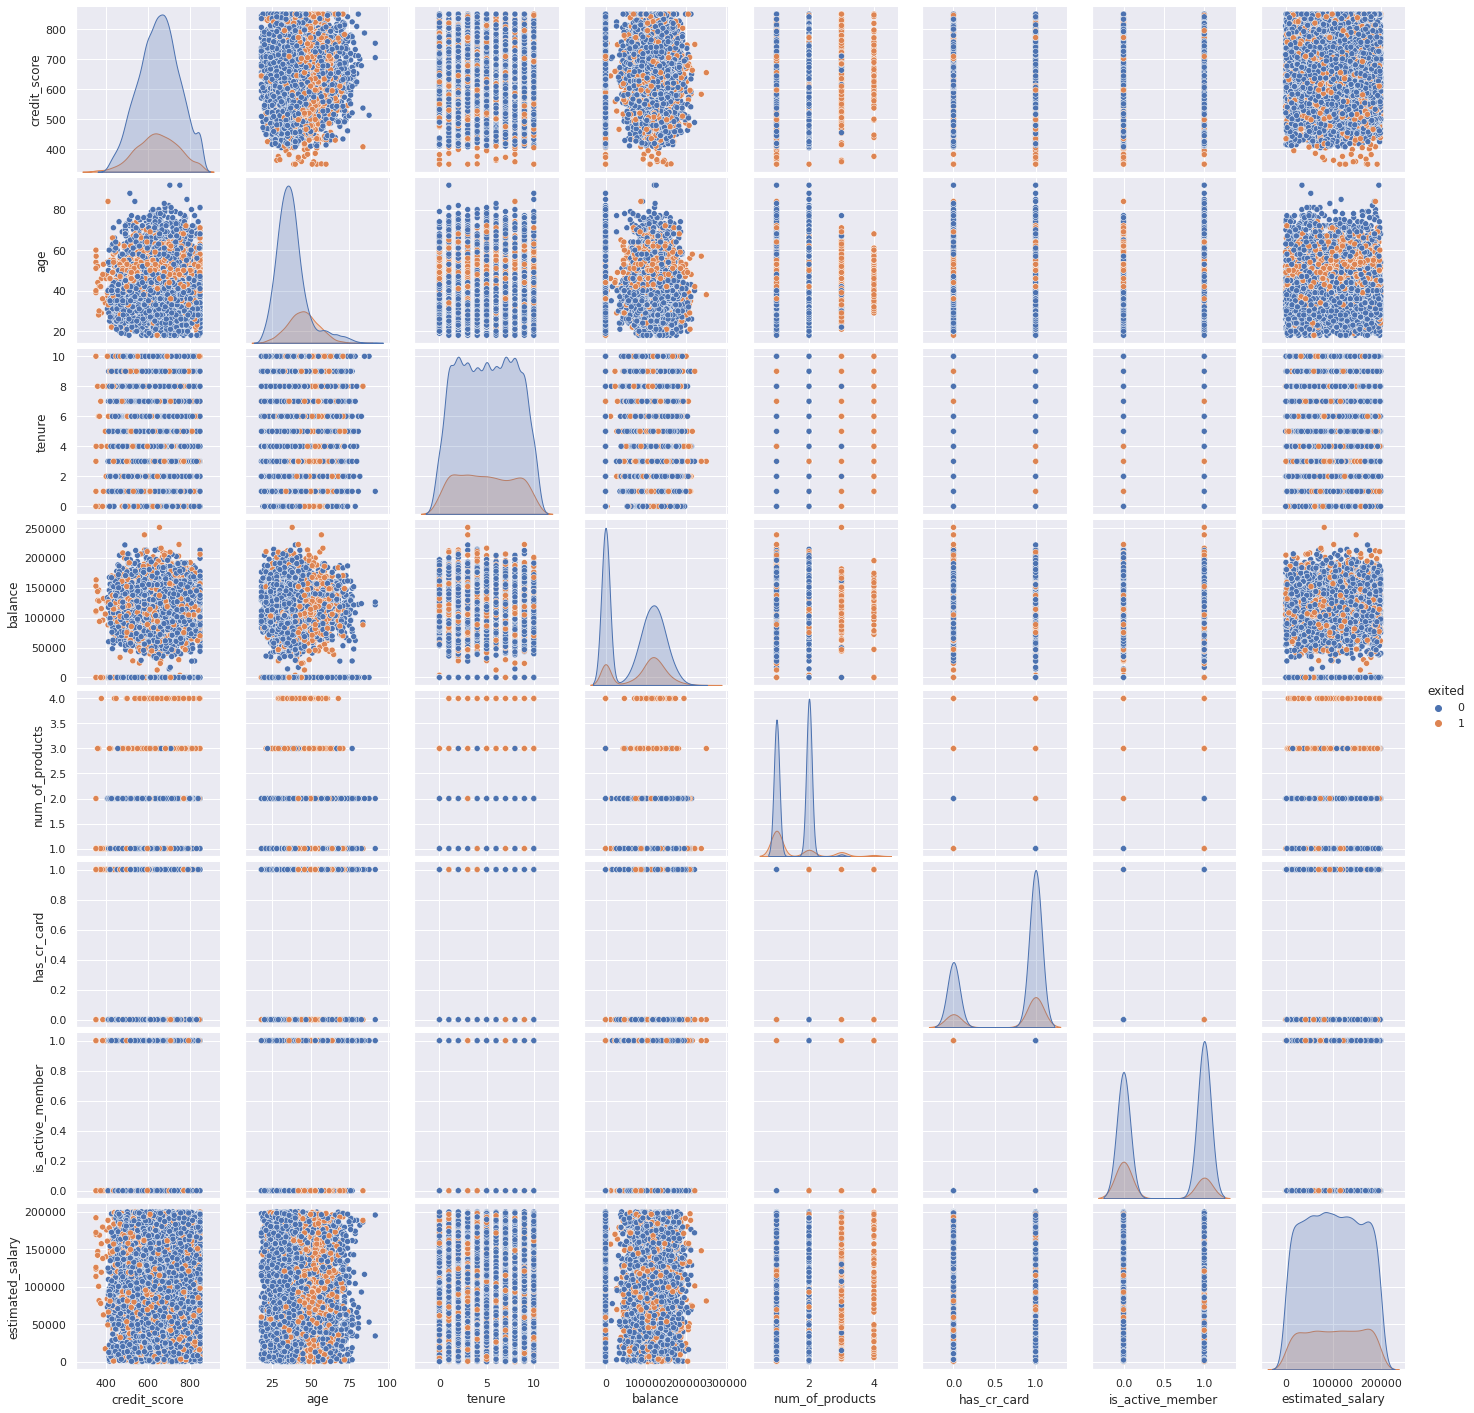

In [9]:
sns.pairplot(data, hue='exited');

Сильной корреляции между признаками и целевым нет. Продолжаем анализ признаков

В стоблце tenure имеются пропуски (чуть менее 10%). Проанализируем данные в столбце

In [10]:
data['tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: tenure, dtype: int64

In [11]:
data['tenure'].isna().sum()

909

Пропуски в стобце tenure удалять нельзя. Возможный вариант заполнение пропусков медианой/средний, но вклад пропусков в значение 5.0 станет слишком существенным. Заполнить пропуски рандомными значениям [0, 10] мне также кажется сомнительной идей для дальнейшего обучения. Мне кажется, что учитывая небольшое кол-во уникальных значений в столбце можно заполнить пропуски техническим -1 и перевести столбец в категориальный

In [12]:
data['tenure'] = data['tenure'].fillna(-1)
data['tenure'] = data['tenure'].astype('object')

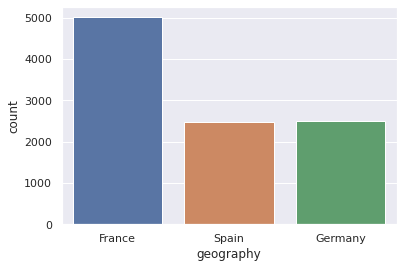

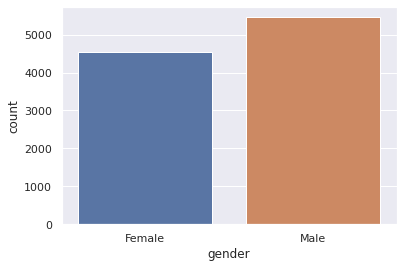

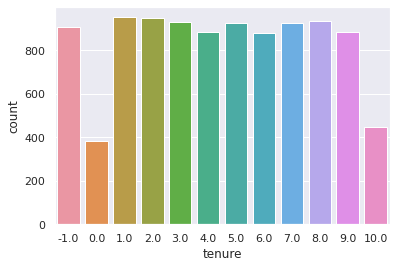

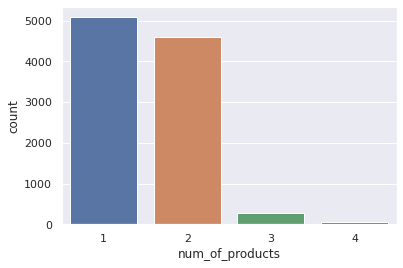

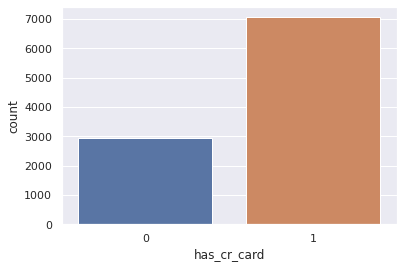

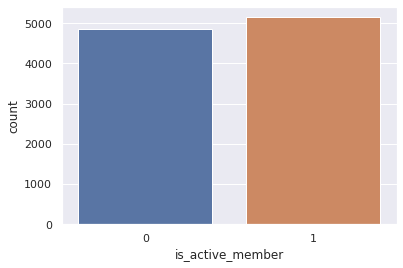

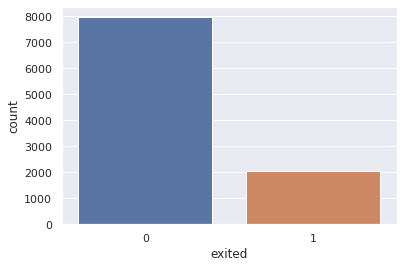

In [13]:
categoricals = ['geography', 'gender', 'tenure', 'num_of_products', 'has_cr_card', 'is_active_member', 'exited']
for column in categoricals:
    sns.countplot(data=data, x=column)
    plt.show()

Кол-во уникальных признаков небольшое. Стоит отметить, что в целевом признаке баланс классов примерно 4:1

Преобразуем все категориальные признаки с помощью OHE

In [14]:
data = pd.get_dummies(data, drop_first=True)

Проанализируем численные признаки

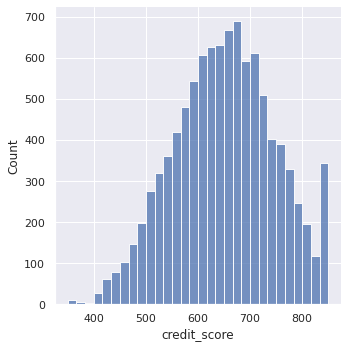

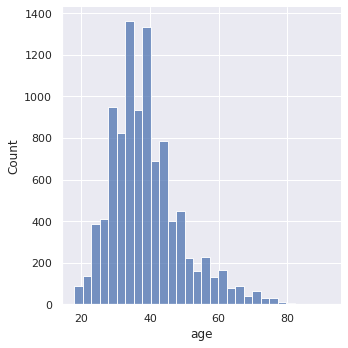

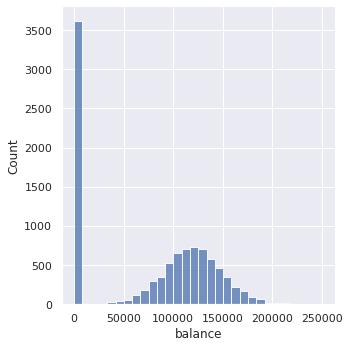

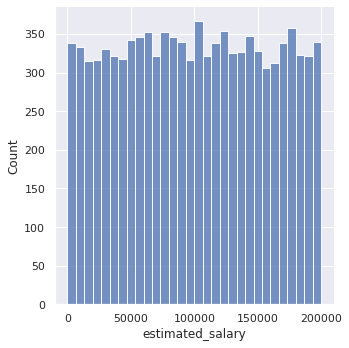

In [15]:
numeric = ['credit_score', 'age', 'balance', 'estimated_salary']
for column in numeric:
    sns.displot(data=data, x=column, bins=30)

Исходя из графиков выше наблюдаются выбросы в стоблцах credit_score и age

In [16]:
data['credit_score'].describe()

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: credit_score, dtype: float64

In [17]:
data['age'].describe()

count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: age, dtype: float64

Выбросы имеются, но они минимальны. Среднее в обоих столбцах практически равно медиане



<b>Предварительный вывод:</b>
- Данные загружены
- Удалены несущественные столбцы
- Переименнованы столбцы
- Изменен тип данных на более рациональный
- Проанализированы и заполены пропуски в tenure
- Категориальные данные подготовлены к обучению с помощью OHE

In [18]:
# итоговая таблица
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_score       10000 non-null  int64  
 1   age                10000 non-null  int64  
 2   balance            10000 non-null  float64
 3   num_of_products    10000 non-null  int8   
 4   has_cr_card        10000 non-null  int8   
 5   is_active_member   10000 non-null  int8   
 6   estimated_salary   10000 non-null  float64
 7   exited             10000 non-null  int8   
 8   geography_Germany  10000 non-null  uint8  
 9   geography_Spain    10000 non-null  uint8  
 10  gender_Male        10000 non-null  uint8  
 11  tenure_0.0         10000 non-null  uint8  
 12  tenure_1.0         10000 non-null  uint8  
 13  tenure_2.0         10000 non-null  uint8  
 14  tenure_3.0         10000 non-null  uint8  
 15  tenure_4.0         10000 non-null  uint8  
 16  tenure_5.0         1000

In [19]:
data.head()

,credit_score,age,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,...,tenure_1.0,tenure_2.0,tenure_3.0,tenure_4.0,tenure_5.0,tenure_6.0,tenure_7.0,tenure_8.0,tenure_9.0,tenure_10.0
0,619,42,0.00,1,1,1,101348.88,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,608,41,83807.86,1,0,1,112542.58,0,0,1,...,1,0,0,0,0,0,0,0,0,0
2,502,42,159660.80,3,1,0,113931.57,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,699,39,0.00,2,0,0,93826.63,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,850,43,125510.82,1,1,1,79084.10,0,0,1,...,0,1,0,0,0,0,0,0,0,0


# Шаг 2. Обучение модели без учета баланса классов

Как было показано в шаге 1 дисбаланс целевого класса 4:1

Разделим выборку на тренировочную, валидационную и тестовую, а также разделим на таблицу признаков и целевого

In [20]:
features = data.drop('exited', axis=1)
target = data['exited']
print(f"Количество строк в target по классам: {np.bincount(target)}")

Количество строк в target по классам: [7963 2037]


In [21]:
features, features_test, target, target_test = train_test_split(
    features, 
    target, 
    test_size=0.2, 
    random_state=12345,
    stratify=target
)
features_train, features_valid, target_train, target_valid = train_test_split(
    features, 
    target, 
    test_size=0.25, 
    random_state=12345,
    stratify=target
)
print(f"Количество строк в target_train по классам: {np.bincount(target_train)}")
print(f"Количество строк в target_valid по классам: {np.bincount(target_valid)}")
print(f"Количество строк в target_test по классам: {np.bincount(target_test)}")

Количество строк в target_train по классам: [4777 1223]
Количество строк в target_valid по классам: [1593  407]
Количество строк в target_test по классам: [1593  407]


In [22]:
print('Вся выборка:\t', data.shape)
print('Тренировочная:\t', features_train.shape)
print('Валидационная:\t', features_valid.shape)
print('Тестовая:\t', features_test.shape)

Вся выборка:	 (10000, 22)
Тренировочная:	 (6000, 21)
Валидационная:	 (2000, 21)
Тестовая:	 (2000, 21)


К численным столбцам применим масштабирование, так как диапозоны значений очень отличаются

In [23]:
scaler = StandardScaler()

scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Для автоматического сбора информации о проведенных экспериментах заведем слудующую структуру данных, которую будем преобразовать в DF после каждого шага с целью последующего анализа

модель, best_f1, best_auc_roc, max_depth, criterion, min_samples_split, min_samples_leaf, model, class_weight, repeat, fraction, score_type, n_estimators

In [24]:
results = []

## Решающее дерево

In [25]:
def upsample(features, target, repeat):
    print()
    print('Размер исходной таблицы:', features.shape)
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    print('Размер upsample zeros:', features_zeros.shape)
    print('Размер upsample ones:', features_ones.shape)

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    
    print('Размер таблицы после upsample:', features_upsampled.shape)
    print()
    
    return features_upsampled, target_upsampled

In [26]:
def downsample(features, target, fraction):
    print()
    print('Размер исходной таблицы:', features.shape)
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    print('Размер downsample zeros:', features_zeros.shape)
    print('Размер downsample ones:', features_ones.shape)
    
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    print('Размер таблицы после downsample:', features_downsampled.shape)
    print()
    
    return features_downsampled, target_downsampled

In [27]:
def decision_tree(features_train, target_train, features_valid, \
                  target_valid, class_weight=None, repeat=1, fraction=1):
    
    if repeat != 1:
        features_train, target_train = upsample(features_train, target_train, repeat)
    if fraction != 1:
        features_train, target_train = downsample(features_train, target_train, fraction)
    
    sub_results_f1 = ['', 0, 0, 0, '', 0, 0, None, class_weight, repeat, fraction, '', 0]
    sub_results_roc_auc = ['', 0, 0, 0, '', 0, 0, None, class_weight, repeat, fraction, '', 0]
    for criterion in ['gini', 'entropy']:
        for samples_split in range(2, 6):
            for samples_leaf in range(1, 10):
                for depth in range(1, 10):
                    model = DecisionTreeClassifier(
                        random_state=12345, 
                        max_depth=depth, 
                        criterion=criterion, 
                        min_samples_split=samples_split, 
                        min_samples_leaf=samples_leaf,
                        class_weight = class_weight
                    )
                    model.fit(
                        features_train, 
                        target_train
                    )
                    
                    predicted_valid = model.predict(features_valid)
                    
                    result_f1_score = f1_score(
                        target_valid, 
                        predicted_valid
                    )
                    if result_f1_score > sub_results_f1[1]:
                        sub_results_f1[0] = 'decision_tree'
                        sub_results_f1[1] = round(result_f1_score, 3)
                        sub_results_f1[3] = depth
                        sub_results_f1[4] = criterion
                        sub_results_f1[5] = samples_split
                        sub_results_f1[6] = samples_leaf
                        sub_results_f1[7] = model
                        sub_results_f1[8] = class_weight
                        sub_results_f1[9] = repeat
                        sub_results_f1[10] = fraction
                        sub_results_f1[11] = 'f1'
                        
                    probabilities_valid = model.predict_proba(features_valid)
                    probabilities_one_valid = probabilities_valid[:, 1]
                    
                    result_roc_auc_score = roc_auc_score(
                        target_valid, 
                        probabilities_one_valid
                    )
                        
                    if result_roc_auc_score > sub_results_roc_auc[2]:
                        sub_results_roc_auc[0] = 'decision_tree'
                        sub_results_roc_auc[2] = round(result_roc_auc_score, 3)
                        sub_results_roc_auc[3] = depth
                        sub_results_roc_auc[4] = criterion
                        sub_results_roc_auc[5] = samples_split
                        sub_results_roc_auc[6] = samples_leaf
                        sub_results_roc_auc[7] = model
                        sub_results_roc_auc[8] = class_weight
                        sub_results_roc_auc[9] = repeat
                        sub_results_roc_auc[10] = fraction
                        sub_results_roc_auc[11] = 'roc_auc'
    results.append(sub_results_f1)
    results.append(sub_results_roc_auc)
    print('-------------------------------------------------------------------------------------')
    print(f'Best {sub_results_f1[11]} ({sub_results_f1[0]}, balance: {sub_results_f1[8]}):', sub_results_f1[1], 
          '\nПараментры лучшей модели:',
          '\nmax_depth:\t\t', sub_results_f1[3], 
          '\ncriterion:\t\t', sub_results_f1[4],
          '\nmin_samples_leaf:\t', sub_results_f1[6],
          '\nbest_min_samples_split:\t', sub_results_f1[5])
    print()
    print(f'Best {sub_results_roc_auc[11]} ({sub_results_roc_auc[0]}, balance: {sub_results_roc_auc[8]}):', \
          sub_results_roc_auc[2], 
          '\nПараментры лучшей модели:',
          '\nmax_depth:\t\t', sub_results_roc_auc[3], 
          '\ncriterion:\t\t', sub_results_roc_auc[4],
          '\nmin_samples_leaf:\t', sub_results_roc_auc[6],
          '\nbest_min_samples_split:\t', sub_results_roc_auc[5])
    print('-------------------------------------------------------------------------------------')
    print()

In [28]:
%%time

decision_tree(features_train, target_train, features_valid, target_valid)

-------------------------------------------------------------------------------------
Best f1 (decision_tree, balance: None): 0.596 
Параментры лучшей модели: 
max_depth:		 8 
criterion:		 gini 
min_samples_leaf:	 5 
best_min_samples_split:	 2

Best roc_auc (decision_tree, balance: None): 0.847 
Параментры лучшей модели: 
max_depth:		 6 
criterion:		 entropy 
min_samples_leaf:	 5 
best_min_samples_split:	 2
-------------------------------------------------------------------------------------

CPU times: user 8.45 s, sys: 1.44 ms, total: 8.45 s
Wall time: 8.47 s


## Случайный лес

In [29]:
def random_forest(features_train, target_train, features_valid, \
                  target_valid, class_weight=None, repeat=1, fraction=1):
    
    if repeat != 1:
        features_train, target_train = upsample(features_train, target_train, repeat)
    if fraction != 1:
        features_train, target_train = downsample(features_train, target_train, fraction)
    
    sub_results_f1 = ['', 0, 0, 0, '', 0, 0, None, class_weight, repeat, fraction, '', 0]
    sub_results_roc_auc = ['', 0, 0, 0, '', 0, 0, None, class_weight, repeat, fraction, '', 0]
    
    for criterion in ['gini', 'entropy']:
        for samples_split in range(2, 6):
            for samples_leaf in range(1, 3):
                for depth in range(1, 10):
                    for n_estimators in range(50, 90, 10):
                        model = RandomForestClassifier(
                            random_state=12345, 
                            max_depth=depth, 
                            criterion=criterion,
                            min_samples_split = samples_split,
                            min_samples_leaf = samples_leaf,
                            n_estimators = n_estimators,
                            class_weight = class_weight
                        )
                        model.fit(
                            features_train, 
                            target_train
                        )

                        predicted_valid = model.predict(features_valid)

                        result_f1_score = f1_score(
                            target_valid, 
                            predicted_valid
                        )
                        if result_f1_score > sub_results_f1[1]:
                            sub_results_f1[0] = 'random_forest'
                            sub_results_f1[1] = round(result_f1_score, 3)
                            sub_results_f1[3] = depth
                            sub_results_f1[4] = criterion
                            sub_results_f1[5] = samples_split
                            sub_results_f1[6] = samples_leaf
                            sub_results_f1[7] = model
                            sub_results_f1[8] = class_weight
                            sub_results_f1[9] = repeat
                            sub_results_f1[10] = fraction
                            sub_results_f1[11] = 'f1'
                            sub_results_f1[12] = n_estimators

                        probabilities_valid = model.predict_proba(features_valid)
                        probabilities_one_valid = probabilities_valid[:, 1]
                    
                        result_roc_auc_score = roc_auc_score(
                            target_valid, 
                            probabilities_one_valid
                        )

                        if result_roc_auc_score > sub_results_roc_auc[2]:
                            sub_results_roc_auc[0] = 'random_forest'
                            sub_results_roc_auc[2] = round(result_roc_auc_score, 3)
                            sub_results_roc_auc[3] = depth
                            sub_results_roc_auc[4] = criterion
                            sub_results_roc_auc[5] = samples_split
                            sub_results_roc_auc[6] = samples_leaf
                            sub_results_roc_auc[7] = model
                            sub_results_roc_auc[8] = class_weight
                            sub_results_roc_auc[9] = repeat
                            sub_results_roc_auc[10] = fraction
                            sub_results_roc_auc[11] = 'roc_auc'
                            sub_results_roc_auc[12] = n_estimators
    results.append(sub_results_f1)
    results.append(sub_results_roc_auc)

    print('-------------------------------------------------------------------------------------')
    print(f'Best {sub_results_f1[11]} ({sub_results_f1[0]}, balance: {sub_results_f1[8]}):', sub_results_f1[1], 
          '\nПараментры лучшей модели:',
          '\nmax_depth:\t\t', sub_results_f1[3], 
          '\ncriterion:\t\t', sub_results_f1[4],
          '\nmin_samples_leaf:\t', sub_results_f1[6],
          '\nbest_min_samples_split:\t', sub_results_f1[5], 
          '\nbest_n_estimators:\t', sub_results_f1[12])
    print()
    print(f'Best {sub_results_roc_auc[11]} ({sub_results_roc_auc[0]}, balance: {sub_results_roc_auc[8]}):', \
          sub_results_roc_auc[2], 
          '\nПараментры лучшей модели:',
          '\nmax_depth:\t\t', sub_results_roc_auc[3], 
          '\ncriterion:\t\t', sub_results_roc_auc[4],
          '\nmin_samples_leaf:\t', sub_results_roc_auc[6],
          '\nbest_min_samples_split:\t', sub_results_roc_auc[5], 
          '\nbest_n_estimators:\t', sub_results_roc_auc[12])
    print('-------------------------------------------------------------------------------------')
    print()

In [30]:
%%time

random_forest(features_train, target_train, features_valid, target_valid)

-------------------------------------------------------------------------------------
Best f1 (random_forest, balance: None): 0.506 
Параментры лучшей модели: 
max_depth:		 9 
criterion:		 entropy 
min_samples_leaf:	 2 
best_min_samples_split:	 5 
best_n_estimators:	 60

Best roc_auc (random_forest, balance: None): 0.876 
Параментры лучшей модели: 
max_depth:		 8 
criterion:		 gini 
min_samples_leaf:	 2 
best_min_samples_split:	 5 
best_n_estimators:	 50
-------------------------------------------------------------------------------------

CPU times: user 1min 32s, sys: 99 ms, total: 1min 32s
Wall time: 1min 32s


## Логистическая регрессия

In [31]:
def logistic_regression(features_train, target_train, features_valid, \
                  target_valid, class_weight=None, repeat=1, fraction=1):
    
    if repeat != 1:
        features_train, target_train = upsample(features_train, target_train, repeat)
    if fraction != 1:
        features_train, target_train = downsample(features_train, target_train, fraction)
    
    sub_results = ['', 0, 0, 0, '', 0, 0, None, class_weight, repeat, fraction, '', 0]
    
    model = LogisticRegression(
        random_state=12345, 
        class_weight=class_weight
    )
    
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    result_f1_score = f1_score(target_valid, predicted_valid)
    
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    result_roc_auc_score = roc_auc_score(target_valid, probabilities_one_valid)
    
    sub_results[0] = 'logistic_regression'
    sub_results[1] = round(result_f1_score, 3)
    sub_results[2] = round(result_roc_auc_score, 3)
    sub_results[7] = model
    sub_results[8] = class_weight
    sub_results[9] = repeat
    sub_results[10] = fraction
    sub_results[11] = 'f1/roc_auc'
    
    results.append(sub_results)
    
    print('-------------------------------------------------------------------------------------')
    print(f'Best f1 ({sub_results[0]}, balance: {sub_results[8]}):', sub_results[1])
    print()
    print(f'Best roc_auc ({sub_results[0]}, balance: {sub_results[8]}):', sub_results[2])
    print('-------------------------------------------------------------------------------------')
    print()

In [32]:
%%time

logistic_regression(features_train, target_train, features_valid, target_valid)

-------------------------------------------------------------------------------------
Best f1 (logistic_regression, balance: None): 0.333

Best roc_auc (logistic_regression, balance: None): 0.786
-------------------------------------------------------------------------------------

CPU times: user 49.9 ms, sys: 220 ms, total: 270 ms
Wall time: 20 ms


In [33]:
df_step_2 = pd.DataFrame(
    results, 
    columns=['model', 
             'best_f1', 
             'best_auc_roc', 
             'max_depth', 
             'criterion', 
             'min_samples_split', 
             'min_samples_leaf', 
             'model', 
             'class_weight', 
             'repeat', 
             'fraction', 
             'score_type', 
             'n_estimators']
)
df_step_2

,model,best_f1,best_auc_roc,max_depth,criterion,min_samples_split,min_samples_leaf,model,class_weight,repeat,fraction,score_type,n_estimators
0,decision_tree,0.596,0.000,8,gini,2,5,"DecisionTreeClassifier(max_depth=8, min_sample...",None,1,1,f1,0
1,decision_tree,0.000,0.847,6,entropy,2,5,"DecisionTreeClassifier(criterion='entropy', ma...",None,1,1,roc_auc,0
2,random_forest,0.506,0.000,9,entropy,5,2,"(DecisionTreeClassifier(criterion='entropy', m...",None,1,1,f1,60
3,random_forest,0.000,0.876,8,gini,5,2,"(DecisionTreeClassifier(max_depth=8, max_featu...",None,1,1,roc_auc,50
4,logistic_regression,0.333,0.786,0,,0,0,LogisticRegression(random_state=12345),None,1,1,f1/roc_auc,0


In [34]:
df_step_2.sort_values(by='best_f1', ascending=False).head(1)

,model,best_f1,best_auc_roc,max_depth,criterion,min_samples_split,min_samples_leaf,model,class_weight,repeat,fraction,score_type,n_estimators
0,decision_tree,0.596,0.0,8,gini,2,5,"DecisionTreeClassifier(max_depth=8, min_sample...",None,1,1,f1,0


In [35]:
df_step_2.sort_values(by='best_auc_roc', ascending=False).head(1)

,model,best_f1,best_auc_roc,max_depth,criterion,min_samples_split,min_samples_leaf,model,class_weight,repeat,fraction,score_type,n_estimators
3,random_forest,0.0,0.876,8,gini,5,2,"(DecisionTreeClassifier(max_depth=8, max_featu...",None,1,1,roc_auc,50


## Выводы по шагу 2

- Исходная выборка разделена на тренировочную, валидационную и тестовую выборки (3:1:1)
- Обучены модели решающего дерева, случайного леса, логистической регрессии
- Лучший результат f1-меры: 0.596
- Лучший результат auc-roc: 0.876

# Шаг 3. Построение моделей с учетом баланса классов

Проблему дисбаланса классов попробуем решить с помощью:
- взвешивания
- upsampling
- downsampling

## Взвешивание

In [36]:
results = []

### Решающее дерево

In [37]:
%%time

decision_tree(features_train, target_train, features_valid, target_valid, class_weight='balanced')

-------------------------------------------------------------------------------------
Best f1 (decision_tree, balance: balanced): 0.582 
Параментры лучшей модели: 
max_depth:		 6 
criterion:		 entropy 
min_samples_leaf:	 3 
best_min_samples_split:	 2

Best roc_auc (decision_tree, balance: balanced): 0.846 
Параментры лучшей модели: 
max_depth:		 6 
criterion:		 entropy 
min_samples_leaf:	 4 
best_min_samples_split:	 2
-------------------------------------------------------------------------------------

CPU times: user 8.89 s, sys: 884 µs, total: 8.9 s
Wall time: 8.92 s


### Случайный лес

In [38]:
%%time

random_forest(features_train, target_train, features_valid, target_valid, class_weight='balanced')

-------------------------------------------------------------------------------------
Best f1 (random_forest, balance: balanced): 0.648 
Параментры лучшей модели: 
max_depth:		 9 
criterion:		 entropy 
min_samples_leaf:	 2 
best_min_samples_split:	 5 
best_n_estimators:	 80

Best roc_auc (random_forest, balance: balanced): 0.875 
Параментры лучшей модели: 
max_depth:		 9 
criterion:		 gini 
min_samples_leaf:	 1 
best_min_samples_split:	 5 
best_n_estimators:	 80
-------------------------------------------------------------------------------------

CPU times: user 1min 33s, sys: 118 ms, total: 1min 34s
Wall time: 1min 34s


### Логистическая регрессия

In [39]:
%%time

logistic_regression(features_train, target_train, features_valid, target_valid, class_weight='balanced')

-------------------------------------------------------------------------------------
Best f1 (logistic_regression, balance: balanced): 0.523

Best roc_auc (logistic_regression, balance: balanced): 0.79
-------------------------------------------------------------------------------------

CPU times: user 45.2 ms, sys: 266 ms, total: 311 ms
Wall time: 24.8 ms


Логистическая регрессия

## Upsample и Downsample

In [40]:
for repeat in [1, 3]:
    for fraction in np.arange(0.55, 1, 0.1):
        decision_tree(
            features_train, 
            target_train, 
            features_valid, 
            target_valid, 
            class_weight='balanced', 
            repeat=repeat, 
            fraction=fraction
        )
        random_forest(
            features_train, 
            target_train, 
            features_valid, 
            target_valid, 
            class_weight='balanced', 
            repeat=repeat, 
            fraction=fraction
        )
        logistic_regression(
            features_train, 
            target_train, 
            features_valid, 
            target_valid, 
            class_weight='balanced', 
            repeat=repeat, 
            fraction=fraction
        )


Размер исходной таблицы: (6000, 21)
Размер downsample zeros: (4777, 21)
Размер downsample ones: (1223, 21)
Размер таблицы после downsample: (3850, 21)

-------------------------------------------------------------------------------------
Best f1 (decision_tree, balance: balanced): 0.584 
Параментры лучшей модели: 
max_depth:		 9 
criterion:		 entropy 
min_samples_leaf:	 8 
best_min_samples_split:	 5

Best roc_auc (decision_tree, balance: balanced): 0.844 
Параментры лучшей модели: 
max_depth:		 5 
criterion:		 gini 
min_samples_leaf:	 9 
best_min_samples_split:	 5
-------------------------------------------------------------------------------------


Размер исходной таблицы: (6000, 21)
Размер downsample zeros: (4777, 21)
Размер downsample ones: (1223, 21)
Размер таблицы после downsample: (3850, 21)

-------------------------------------------------------------------------------------
Best f1 (random_forest, balance: balanced): 0.638 
Параментры лучшей модели: 
max_depth:		 9 
criterio

-------------------------------------------------------------------------------------
Best f1 (decision_tree, balance: balanced): 0.572 
Параментры лучшей модели: 
max_depth:		 6 
criterion:		 entropy 
min_samples_leaf:	 6 
best_min_samples_split:	 2

Best roc_auc (decision_tree, balance: balanced): 0.847 
Параментры лучшей модели: 
max_depth:		 6 
criterion:		 entropy 
min_samples_leaf:	 9 
best_min_samples_split:	 5
-------------------------------------------------------------------------------------


Размер исходной таблицы: (6000, 21)
Размер upsample zeros: (4777, 21)
Размер upsample ones: (1223, 21)
Размер таблицы после upsample: (8446, 21)


Размер исходной таблицы: (8446, 21)
Размер downsample zeros: (4777, 21)
Размер downsample ones: (3669, 21)
Размер таблицы после downsample: (6296, 21)

-------------------------------------------------------------------------------------
Best f1 (random_forest, balance: balanced): 0.623 
Параментры лучшей модели: 
max_depth:		 9 
criterion:	

-------------------------------------------------------------------------------------
Best f1 (decision_tree, balance: balanced): 0.574 
Параментры лучшей модели: 
max_depth:		 7 
criterion:		 gini 
min_samples_leaf:	 8 
best_min_samples_split:	 5

Best roc_auc (decision_tree, balance: balanced): 0.843 
Параментры лучшей модели: 
max_depth:		 5 
criterion:		 gini 
min_samples_leaf:	 9 
best_min_samples_split:	 5
-------------------------------------------------------------------------------------


Размер исходной таблицы: (6000, 21)
Размер upsample zeros: (4777, 21)
Размер upsample ones: (1223, 21)
Размер таблицы после upsample: (8446, 21)


Размер исходной таблицы: (8446, 21)
Размер downsample zeros: (4777, 21)
Размер downsample ones: (3669, 21)
Размер таблицы после downsample: (8207, 21)

-------------------------------------------------------------------------------------
Best f1 (random_forest, balance: balanced): 0.632 
Параментры лучшей модели: 
max_depth:		 9 
criterion:		 gini

In [41]:
df_step_3 = pd.DataFrame(
    results, 
    columns=['model', 
             'best_f1', 
             'best_auc_roc', 
             'max_depth', 
             'criterion', 
             'min_samples_split', 
             'min_samples_leaf', 
             'model', 
             'class_weight', 
             'repeat', 
             'fraction', 
             'score_type', 
             'n_estimators']
)
df_step_3.head()

,model,best_f1,best_auc_roc,max_depth,criterion,min_samples_split,min_samples_leaf,model,class_weight,repeat,fraction,score_type,n_estimators
0,decision_tree,0.582,0.000,6,entropy,2,3,DecisionTreeClassifier(class_weight='balanced'...,balanced,1,1.0,f1,0
1,decision_tree,0.000,0.846,6,entropy,2,4,DecisionTreeClassifier(class_weight='balanced'...,balanced,1,1.0,roc_auc,0
2,random_forest,0.648,0.000,9,entropy,5,2,"(DecisionTreeClassifier(criterion='entropy', m...",balanced,1,1.0,f1,80
3,random_forest,0.000,0.875,9,gini,5,1,"(DecisionTreeClassifier(max_depth=9, max_featu...",balanced,1,1.0,roc_auc,80
4,logistic_regression,0.523,0.790,0,,0,0,"LogisticRegression(class_weight='balanced', ra...",balanced,1,1.0,f1/roc_auc,0


In [42]:
df_step_3.query('best_f1 > 0.59').sort_values(by='best_f1', ascending=False)

,model,best_f1,best_auc_roc,max_depth,criterion,min_samples_split,min_samples_leaf,model,class_weight,repeat,fraction,score_type,n_estimators
22,random_forest,0.653,0.0,9,gini,2,1,"(DecisionTreeClassifier(max_depth=9, max_featu...",balanced,1,0.85,f1,50
2,random_forest,0.648,0.0,9,entropy,5,2,"(DecisionTreeClassifier(criterion='entropy', m...",balanced,1,1.00,f1,80
27,random_forest,0.646,0.0,9,entropy,2,1,"(DecisionTreeClassifier(criterion='entropy', m...",balanced,1,0.95,f1,80
17,random_forest,0.644,0.0,9,entropy,5,1,"(DecisionTreeClassifier(criterion='entropy', m...",balanced,1,0.75,f1,70
12,random_forest,0.641,0.0,9,gini,2,1,"(DecisionTreeClassifier(max_depth=9, max_featu...",balanced,1,0.65,f1,60
7,random_forest,0.638,0.0,9,gini,2,2,"(DecisionTreeClassifier(max_depth=9, max_featu...",balanced,1,0.55,f1,80
42,random_forest,0.635,0.0,9,gini,4,2,"(DecisionTreeClassifier(max_depth=9, max_featu...",balanced,3,0.75,f1,70
37,random_forest,0.633,0.0,9,entropy,2,2,"(DecisionTreeClassifier(criterion='entropy', m...",balanced,3,0.65,f1,80
47,random_forest,0.632,0.0,9,entropy,4,2,"(DecisionTreeClassifier(criterion='entropy', m...",balanced,3,0.85,f1,80
52,random_forest,0.632,0.0,9,gini,3,1,"(DecisionTreeClassifier(max_depth=9, max_featu...",balanced,3,0.95,f1,80


In [43]:
df_step_3.query('best_f1 > 0.59').sort_values(by='best_f1', ascending=False).shape

(11, 13)

<b>Выводы по шагу 3:</b>
Для минимизации дисбаланса целевого класса были применены
- взвешивание
- upsampling
- downsampling

Все проведено 54 эксперимента, из которых удовлетворяют условию задачи 11.

Лучшие модели были получены с помощью случайного леса.

F1 - 0.653, max_depth=9, repeat=1, fraction=0.85, n_estimators=50, balanced

F1 - 0.648, max_depth=9, repeat=1, fraction=1, n_estimators=80, balanced

# Шаг 4. Проверка на тестовой выборке

Для тестирования моделей объединим данные тренировочной и валидационной выборки

In [44]:
features_final = pd.concat([features_train, features_valid], ignore_index=True)
target_final = pd.concat([target_train, target_valid], ignore_index=True)
features_final.shape

(8000, 21)

## 1-ая модель

repeat=1, fraction=1

In [45]:
model_final_1 = RandomForestClassifier(
    random_state=12345, 
    n_estimators=80, 
    max_depth=9, 
    criterion='entropy', 
    min_samples_split=5, 
    min_samples_leaf=2, 
    class_weight='balanced'
)
model_final_1.fit(features_final, target_final)

predicted_final = model_final_1.predict(features_test)
f1 = f1_score(target_test, predicted_final)

probabilities_valid = model_final_1.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc = roc_auc_score(target_test, probabilities_one_valid)

print(f'f1 на тестовой выборке:', f1)
print(f'roc_auc на тестовой выборке:', roc_auc)

f1 на тестовой выборке: 0.635091496232508
roc_auc на тестовой выборке: 0.8671414095142909


# 2-ая модель

repeat=1, fraction=0.85

In [46]:
features_final, target_final = downsample(features_final, target_final, 0.85)


Размер исходной таблицы: (8000, 21)
Размер downsample zeros: (6370, 21)
Размер downsample ones: (1630, 21)
Размер таблицы после downsample: (7044, 21)



In [47]:
model_final_2 = RandomForestClassifier(
    random_state=12345, 
    n_estimators=50, 
    max_depth=9, 
    criterion='gini', 
    min_samples_split=4, 
    min_samples_leaf=1, 
    class_weight='balanced'
)
model_final_2.fit(features_final, target_final)

predicted_final = model_final_2.predict(features_test)
f1 = f1_score(target_test, predicted_final)

probabilities_valid = model_final_2.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc = roc_auc_score(target_test, probabilities_one_valid)

print(f'f1 на тестовой выборке:', f1)
print(f'roc_auc на тестовой выборке:', roc_auc)

f1 на тестовой выборке: 0.6266375545851528
roc_auc на тестовой выборке: 0.8637512705309316


<b>Выводы</b>

Обе лучшие модели показали удовлетворительный результат на тестовой выборке

F1 0.635 и 0,627

Есть небольшой эффект переобучения

In [48]:
dummy_model = DummyClassifier(strategy='constant', constant=1, random_state=12345)

dummy_model.fit(features_final, target_final)

result_dummy = dummy_model.predict(features_test)

# result_dummy.shape
f1_dummy = f1_score(target_test, result_dummy)
# np.unique(result_dummy)
print('f1 Dummy модели: ', round(f1_dummy, 3))

f1 Dummy модели:  0.338


# Шаг 5. Выводы

1. Получение данных
- Данные загружены
- Удалены несущественные столбцы
- Переименнованы столбцы
- Изменен тип данных на более рациональный
- Проанализированы и заполены пропуски в tenure
- Категориальные данные подготовлены к обучению с помощью OHE
- Численные данных отмасштабированы
2. Построение моделей без учета учета баланса классов
- Исходная выборка разделена на тренировочную, валидационную и тестовую выборки (3:1:1)
- Обучены модели решающего дерева, случайного леса, логистической регрессии
- Лучший результат f1-меры: 0.566
- Лучший результат auc-roc: 0.712
- Ни одна модель не удовлетворила требованиям задания
3. Построение моделей с учетом балансов класса
- Взвешенивание
- Upsampling
- Downsampling
- Проведено больше ста расчетов на тренировочной и валидационной выборках
- 12 расчетов удовлетворили условиям задачи
- Во всех 12 расчетах присуствует набор из разных параметров. Какой либо тенденции не угадывается
4. Проверка двух лучших моделей на тестовой выборке
- Модели обучены на объединенной тренировочной и валидационной выборках
- Примененны параметры двух самых успешных моделей, которые также успешно прошли тест
- Значения f1 на тестовой выбоки 0.641 и 0.639